In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi
from shapely.geometry import Polygon, box



District 0: Party 3 won with 0.54 of the vote
District 1: Party 1 won with 0.30 of the vote
District 2: Party 0 won with 0.52 of the vote
District 3: Party 1 won with 0.42 of the vote
District 4: Party 2 won with 0.55 of the vote
District 5: Party 1 won with 0.51 of the vote
District 6: Party 1 won with 0.58 of the vote
District 7: Party 2 won with 0.56 of the vote


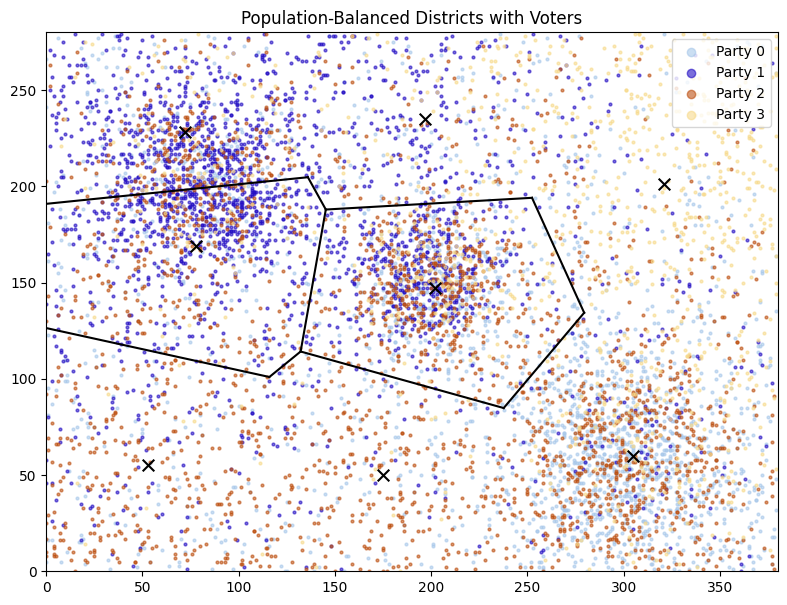

In [ ]:

# ============================================================
# PARAMETERS (ONLY CHANGE THESE)
# ============================================================

WIDTH = 380
HEIGHT = 280

NUM_VOTERS = 8000
NUM_DISTRICTS = 8
NUM_PARTIES = 4
NUM_RUNS = 50

CITIES = [
    (80, 200, 8, 25),
    (300, 60, 6, 30),
    (200, 150, 10, 20)
]

# ============================================================
# POPULATION DENSITY WITH CITIES
# ============================================================

def generate_population_density(width, height, cities, base_density=1.0):
    density = np.full((height, width), base_density)
    X, Y = np.meshgrid(np.arange(width), np.arange(height))

    for cx, cy, intensity, sigma in cities:
        density += intensity * np.exp(
            -((X - cx)**2 + (Y - cy)**2) / (2 * sigma**2)
        )

    return density

# ============================================================
# SAMPLE FIXED POPULATION
# ============================================================

def sample_population_from_density(density, n_voters):
    flat = density.flatten()
    probs = flat / flat.sum()
    indices = np.random.choice(len(flat), size=n_voters, p=probs)
    ys, xs = np.divmod(indices, density.shape[1])
    return np.column_stack((xs, ys))

# ============================================================
# POPULATION-BALANCED DISTRICTS (K-MEANS STYLE)
# ============================================================

def generate_population_balanced_centers(voters, num_districts, iters=25):
    centers = voters[np.random.choice(len(voters), num_districts, replace=False)]

    for _ in range(iters):
        distances = np.linalg.norm(voters[:, None, :] - centers[None, :, :], axis=2)
        assignments = np.argmin(distances, axis=1)

        for i in range(num_districts):
            pts = voters[assignments == i]
            if len(pts) > 0:
                centers[i] = pts.mean(axis=0)

    return centers

def assign_districts(voters, centers):
    distances = np.linalg.norm(voters[:, None, :] - centers[None, :, :], axis=2)
    return np.argmin(distances, axis=1)

# ============================================================
# PARTY PREFERENCE MODEL (GENERIC, SCALABLE)
# ============================================================

def generate_party_preferences(num_parties, width, height):
    centers = np.column_stack([
        np.random.uniform(0, width, num_parties),
        np.random.uniform(0, height, num_parties)
    ])
    strengths = np.random.uniform(0.5, 1.5, num_parties)

    def preference_fn(x, y):
        dists = np.linalg.norm(centers - np.array([x, y]), axis=1)
        weights = strengths * np.exp(-dists / 80)
        return weights / weights.sum()

    return preference_fn

def assign_parties(voters, preference_fn, num_parties):
    parties = []
    for x, y in voters:
        probs = preference_fn(x, y)
        parties.append(np.random.choice(num_parties, p=probs))
    return np.array(parties)

# ============================================================
# DISTRICT RESULTS (WINNER + VOTE PROPORTION ONLY)
# ============================================================

def district_results(voter_parties, district_assignments, num_parties):
    results = []

    for d in range(district_assignments.max() + 1):
        mask = district_assignments == d
        votes = np.bincount(voter_parties[mask], minlength=num_parties)
        total = votes.sum()

        winner = np.argmax(votes)
        proportion = votes[winner] / total if total > 0 else 0

        results.append({
            "district": d,
            "winner": winner,
            "vote_share": proportion
        })

    return results

# ============================================================
# RANDOM PARTY COLORS
# ============================================================

def generate_party_colors(num_parties):
    return {i: np.random.rand(3,) for i in range(num_parties)}

# ============================================================
# BUILD FIXED MAP
# ============================================================

density = generate_population_density(WIDTH, HEIGHT, CITIES)
voters = sample_population_from_density(density, NUM_VOTERS)

centers = generate_population_balanced_centers(voters, NUM_DISTRICTS)
district_assignments = assign_districts(voters, centers)

party_preferences = generate_party_preferences(NUM_PARTIES, WIDTH, HEIGHT)
party_colors = generate_party_colors(NUM_PARTIES)

# ============================================================
# RUN MULTIPLE ELECTIONS
# ============================================================

all_results = []

for _ in range(NUM_RUNS):
    voter_parties = assign_parties(voters, party_preferences, NUM_PARTIES)
    results = district_results(voter_parties, district_assignments, NUM_PARTIES)
    all_results.append(results)

# Print example output
for r in all_results[0]:
    print(f"District {r['district']}: Party {r['winner']} "
          f"won with {r['vote_share']:.2f} of the vote")

# ============================================================
# VISUALIZE ONE ELECTION
# ============================================================


def plot_voronoi(ax, centers, width, height):
    vor = Voronoi(centers)

    for ridge in vor.ridge_vertices:
        if -1 in ridge:
            continue
        v0, v1 = vor.vertices[ridge]
        ax.plot([v0[0], v1[0]], [v0[1], v1[1]],
                color="black", linewidth=1.5)


voter_parties = assign_parties(voters, party_preferences, NUM_PARTIES)

fig, ax = plt.subplots(figsize=(10, 7))

# Plot districts
plot_voronoi(ax, centers, WIDTH, HEIGHT)

# Plot voters by party
for i in range(NUM_PARTIES):
    mask = voter_parties == i
    ax.scatter(
        voters[mask, 0],
        voters[mask, 1],
        s=4,
        color=party_colors[i],
        label=f"Party {i}",
        alpha=0.6
    )

# Plot district centers
ax.scatter(centers[:, 0], centers[:, 1], c="black", s=70, marker="x")

ax.set_xlim(0, WIDTH)
ax.set_ylim(0, HEIGHT)
ax.set_aspect("equal")
ax.set_title("Population-Balanced Districts with Voters")
ax.legend(markerscale=3)
plt.show()



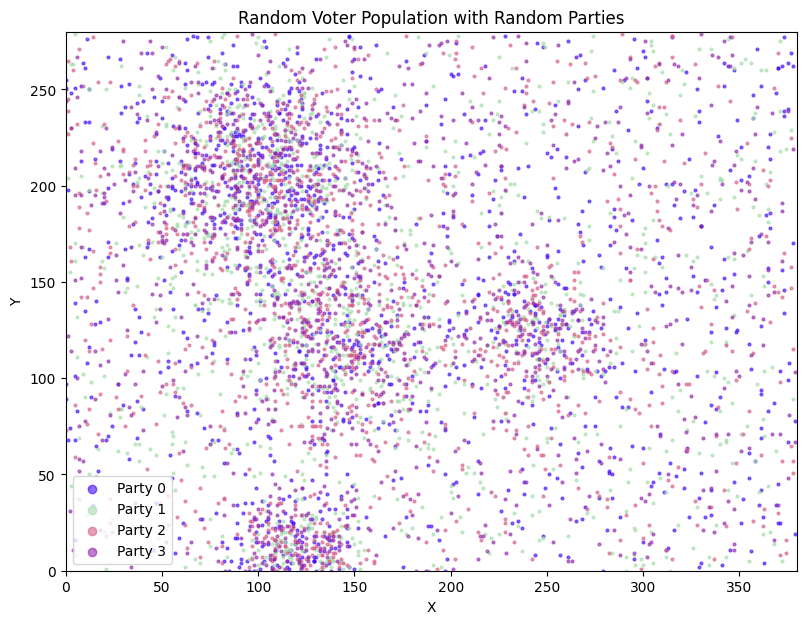

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------
# Map and population setup
# ------------------------
WIDTH = 380
HEIGHT = 280
NUM_VOTERS = 5000

NUM_PARTIES = 4  # number of different parties/colors

# Random city parameters
NUM_CITIES = 5
CITY_INTENSITY = (5, 12)
CITY_SPREAD = (10, 30)

# Base population density
density = np.full((HEIGHT, WIDTH), 1.0)
X, Y = np.meshgrid(np.arange(WIDTH), np.arange(HEIGHT))

# Generate random cities
for _ in range(NUM_CITIES):
    cx = np.random.uniform(0, WIDTH)
    cy = np.random.uniform(0, HEIGHT)
    intensity = np.random.uniform(*CITY_INTENSITY)
    sigma = np.random.uniform(*CITY_SPREAD)
    density += intensity * np.exp(-((X - cx)**2 + (Y - cy)**2) / (2 * sigma**2))

# ------------------------
# Sample voter coordinates
# ------------------------
flat = density.flatten()
probs = flat / flat.sum()
indices = np.random.choice(len(flat), size=NUM_VOTERS, p=probs)
ys, xs = np.divmod(indices, WIDTH)
voters = np.column_stack((xs, ys))

# ------------------------
# Assign random parties/colors
# ------------------------
voter_parties = np.random.randint(0, NUM_PARTIES, size=NUM_VOTERS)
party_colors = np.random.rand(NUM_PARTIES, 3)  # random RGB colors

# ------------------------
# Plot
# ------------------------
plt.figure(figsize=(10,7))
for i in range(NUM_PARTIES):
    mask = voter_parties == i
    plt.scatter(voters[mask,0], voters[mask,1], 
                s=4, color=party_colors[i], label=f'Party {i}', alpha=0.6)

plt.title("Random Voter Population with Random Parties")
plt.xlabel("X")
plt.ylabel("Y")
plt.xlim(0, WIDTH)
plt.ylim(0, HEIGHT)
plt.gca().set_aspect('equal')
plt.legend(markerscale=3)
plt.show()


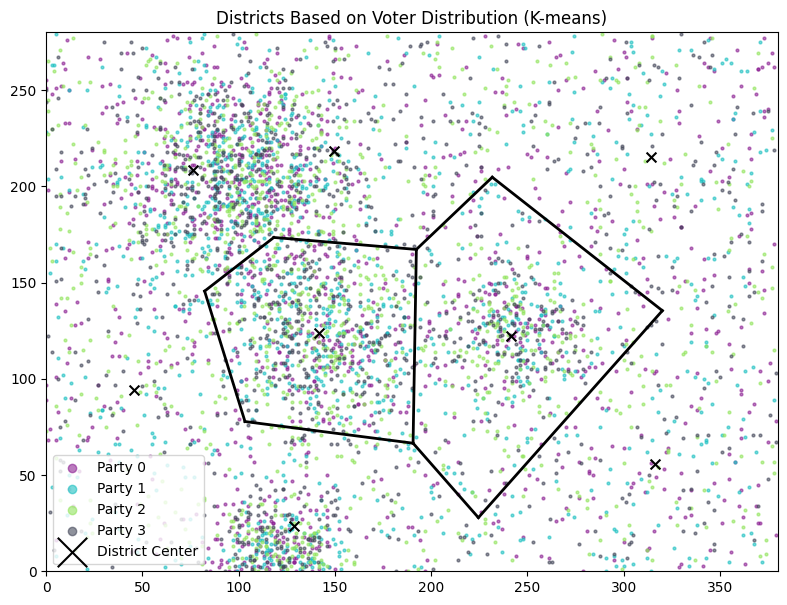

District 0: 940 voters
District 1: 403 voters
District 2: 1092 voters
District 3: 653 voters
District 4: 644 voters
District 5: 302 voters
District 6: 352 voters
District 7: 614 voters


In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.spatial import Voronoi

# ------------------------
# Assume your voter setup is done
# voters: Nx2 array of voter coordinates
# voter_parties: length N array
# ------------------------

NUM_DISTRICTS = 8

# 1. Cluster voters with K-means
kmeans = KMeans(n_clusters=NUM_DISTRICTS, n_init=20, random_state=42)
assignments = kmeans.fit_predict(voters)
district_centers = kmeans.cluster_centers_

# 2. Plot voters colored by party
NUM_PARTIES = np.max(voter_parties)+1
party_colors = np.random.rand(NUM_PARTIES, 3)

plt.figure(figsize=(10,7))
for i in range(NUM_PARTIES):
    mask = voter_parties == i
    plt.scatter(voters[mask,0], voters[mask,1], 
                s=4, color=party_colors[i], label=f'Party {i}', alpha=0.6)

# 3. Plot district boundaries using Voronoi on cluster centers
vor = Voronoi(district_centers)
for ridge_vertices in vor.ridge_vertices:
    if -1 in ridge_vertices:
        continue
    v0, v1 = vor.vertices[ridge_vertices]
    if 0 <= v0[0] <= 380 and 0 <= v0[1] <= 280 and 0 <= v1[0] <= 380 and 0 <= v1[1] <= 280:
        plt.plot([v0[0], v1[0]], [v0[1], v1[1]], 'k-', lw=2)

# 4. Plot district centers
plt.scatter(district_centers[:,0], district_centers[:,1], c='black', s=50, marker='x', label='District Center')

plt.title("Districts Based on Voter Distribution (K-means)")
plt.xlim(0, 380)
plt.ylim(0, 280)
plt.gca().set_aspect('equal')
plt.legend(markerscale=3)
plt.show()

# 5. Check voters per district
unique, counts = np.unique(assignments, return_counts=True)
for i, c in zip(unique, counts):
    print(f"District {i}: {c} voters")


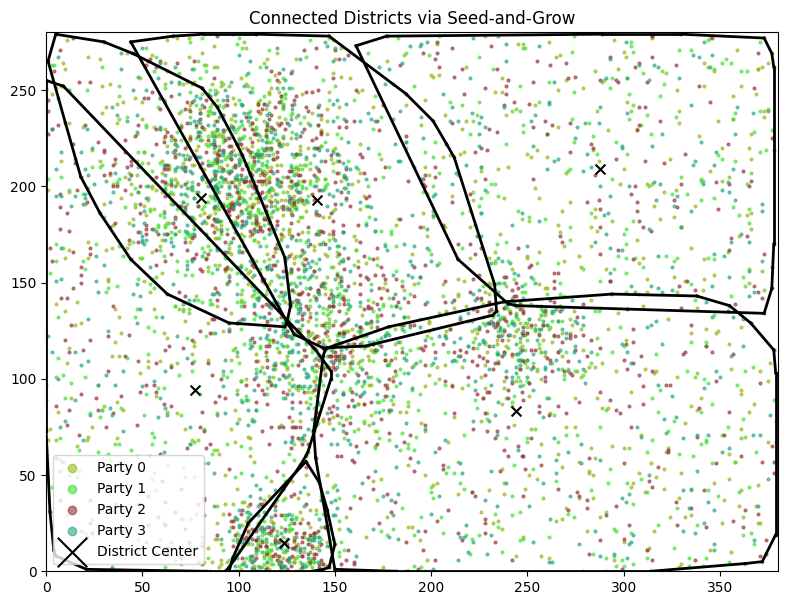

District 0: 740 voters
District 1: 1206 voters
District 2: 1173 voters
District 3: 591 voters
District 4: 957 voters
District 5: 333 voters


In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

# ------------------------
# Parameters
# ------------------------
NUM_DISTRICTS = 6

# voters: Nx2 array of coordinates from your existing code
# voter_parties: array of length N with party assignments

# ------------------------
# Seed-and-grow clustering
# ------------------------
N = len(voters)
district_assignments = -np.ones(N, dtype=int)  # -1 = unassigned

# Step 1: pick initial seeds randomly
seed_indices = np.random.choice(N, size=NUM_DISTRICTS, replace=False)
district_assignments[seed_indices] = np.arange(NUM_DISTRICTS)

# Step 2: Build KDTree for fast neighbor search
tree = cKDTree(voters)

# Step 3: Grow districts
frontiers = [ [idx] for idx in seed_indices ]  # list of voter indices for each district frontier

while np.any(district_assignments == -1):
    for d in range(NUM_DISTRICTS):
        new_frontier = []
        for v in frontiers[d]:
            # Find nearest neighbors (you can adjust k for growth speed)
            distances, neighbors = tree.query(voters[v], k=8)
            for n in neighbors:
                if district_assignments[n] == -1:
                    district_assignments[n] = d
                    new_frontier.append(n)
        frontiers[d] = new_frontier

# Step 4: Compute district centers for plotting
district_centers = np.array([voters[district_assignments==d].mean(axis=0) for d in range(NUM_DISTRICTS)])

# ------------------------
# Plot
# ------------------------
plt.figure(figsize=(10,7))

NUM_PARTIES = np.max(voter_parties)+1
party_colors = np.random.rand(NUM_PARTIES, 3)

for i in range(NUM_PARTIES):
    mask = voter_parties == i
    plt.scatter(voters[mask,0], voters[mask,1], 
                s=4, color=party_colors[i], label=f'Party {i}', alpha=0.6)

# Plot district boundaries approximately using convex hulls
from scipy.spatial import ConvexHull

for d in range(NUM_DISTRICTS):
    pts = voters[district_assignments==d]
    if len(pts) > 2:
        hull = ConvexHull(pts)
        for simplex in hull.simplices:
            plt.plot(pts[simplex,0], pts[simplex,1], 'k-', lw=2)

# Plot district centers
plt.scatter(district_centers[:,0], district_centers[:,1], c='black', s=50, marker='x', label='District Center')

plt.title("Connected Districts via Seed-and-Grow")
plt.xlim(0, 380)
plt.ylim(0, 280)
plt.gca().set_aspect('equal')
plt.legend(markerscale=3)
plt.show()

# ------------------------
# Check voters per district
# ------------------------
unique, counts = np.unique(district_assignments, return_counts=True)
for i, c in zip(unique, counts):
    print(f"District {i}: {c} voters")
